In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

This notebook demonstrates all of the analysis done on the DF-BP models. It is split into sections based on the analyses performed. The ML model predictions can be found in the `DF-BP` subfolder.

# Train/Val/Test Sizes

In [2]:
b3lyp_train = pd.read_csv('DF-BP/b3lyp_opt0/BP_predictions_hyperparams-train.csv')
b3lyp_val = pd.read_csv('DF-BP/b3lyp_opt0/BP_predictions_hyperparams-val.csv')
b3lyp_test = pd.read_csv('DF-BP/b3lyp_opt0/BP_predictions_hyperparams-test.csv')
print(f'The training/validation/test sizes for B3LYP PBEx are {len(b3lyp_train["PBE Prediction"].dropna())}/{len(b3lyp_val["PBE Prediction"].dropna())}/{len(b3lyp_test["PBE Prediction"].dropna())}.')
print(f'The training/validation/test sizes for B3LYP SCANx are {len(b3lyp_train["SCAN Prediction"].dropna())}/{len(b3lyp_val["SCAN Prediction"].dropna())}/{len(b3lyp_test["SCAN Prediction"].dropna())}.')

pbe0_train = pd.read_csv('DF-BP/pbe0_opt0/BP_predictions_hyperparams-train.csv')
pbe0_val = pd.read_csv('DF-BP/pbe0_opt0/BP_predictions_hyperparams-val.csv')
pbe0_test = pd.read_csv('DF-BP/pbe0_opt0/BP_predictions_hyperparams-test.csv')
print(f'The training/validation/test sizes for PBE0 PBEx are {len(pbe0_train["PBE Prediction"].dropna())}/{len(pbe0_val["PBE Prediction"].dropna())}/{len(pbe0_test["PBE Prediction"].dropna())}.')
print(f'The training/validation/test sizes for PBE0 SCANx are {len(pbe0_train["SCAN Prediction"].dropna())}/{len(pbe0_val["SCAN Prediction"].dropna())}/{len(pbe0_test["SCAN Prediction"].dropna())}.')

scan0_train = pd.read_csv('DF-BP/scan0_opt0/BP_predictions_hyperparams-train.csv')
scan0_val = pd.read_csv('DF-BP/scan0_opt0/BP_predictions_hyperparams-val.csv')
scan0_test = pd.read_csv('DF-BP/scan0_opt0/BP_predictions_hyperparams-test.csv')
print(f'The training/validation/test sizes for SCAN0 PBEx are {len(scan0_train["PBE Prediction"].dropna())}/{len(scan0_val["PBE Prediction"].dropna())}/{len(scan0_test["PBE Prediction"].dropna())}.')
print(f'The training/validation/test sizes for SCAN0 SCANx are {len(scan0_train["SCAN Prediction"].dropna())}/{len(scan0_val["SCAN Prediction"].dropna())}/{len(scan0_test["SCAN Prediction"].dropna())}.')

vss_df = pd.read_csv('../ml_features/BP_features/b3lyp-vss452_structures.csv')
vss_df2 = pd.read_csv('../ml_features/BP_features/pbe0-vss452_structures.csv')
vss_df3 = pd.read_csv('../ml_features/BP_features/scan0-vss452_structures.csv')

set1 = set(vss_df['Unnamed: 0'].to_list())
set2 = set(vss_df2['Unnamed: 0'].to_list())
set3 = set(vss_df3['Unnamed: 0'].to_list())
vss_common_structs = set1 & set2 & set3

csd_df = pd.read_csv('../ml_features/BP_features/b3lyp-csd76_structures.csv')
csd_df2 = pd.read_csv('../ml_features/BP_features/pbe0-csd76_structures.csv')
csd_df3 = pd.read_csv('../ml_features/BP_features/scan0-csd76_structures.csv')

set1 = set(csd_df['Unnamed: 0'].to_list())
set2 = set(csd_df2['Unnamed: 0'].to_list())
set3 = set(csd_df3['Unnamed: 0'].to_list())
csd_common_structs = set1 & set2 & set3

train_common = len(set(pbe0_train['Unnamed: 0']).intersection(vss_common_structs))
val_common = len(set(pbe0_val['Unnamed: 0']).intersection(vss_common_structs))
test_common = len(set(pbe0_test['Unnamed: 0']).intersection(csd_common_structs))
print(f'The training/validation/test sizes for the common split are {train_common}/{val_common}/{test_common}.')

The training/validation/test sizes for B3LYP PBEx are 205/30/51.
The training/validation/test sizes for B3LYP SCANx are 205/24/50.
The training/validation/test sizes for PBE0 PBEx are 297/51/65.
The training/validation/test sizes for PBE0 SCANx are 297/34/63.
The training/validation/test sizes for SCAN0 PBEx are 285/35/63.
The training/validation/test sizes for SCAN0 SCANx are 285/35/63.
The training/validation/test sizes for the common split are 184/21/47.


# Get Tuned Hyperparameters

In [3]:
base_functional = 'scan0' #'b3lyp', 'pbe0', 'scan0'
tuned_functional = 'scan' #'pbe', 'scan'

for split in np.arange(5, 6):
    with open('DF-BP/' + base_functional + '_opt' + str(split) + '/' + tuned_functional + '_optimal_hps.txt', 'r') as f:
        print('===================')
        print(f'{base_functional}, split {split}, tuned for {tuned_functional}:')
        for line in f.readlines():
            print(line)

scan0, split 5, tuned for scan:


n_out: 10

n_hidden: 8

n_layers: 5

droprate: 0.3



# Model errors

In [4]:
#get errors in HFX% - base_functional is input density, tuned_functional is PBEx or SCANx

runs = [str(x) for x in np.arange(0, 6)]
base_functional = 'pbe0' #'b3lyp', 'pbe0', 'scan0'
tuned_functional = 'scan' #'pbe', 'scan'

#metrics = ['train_r2', 'train_mae', 'val_r2', 'val_mae', 'test_r2', 'test_mae']
metrics = ['train_mae', 'val_mae', 'test_mae']

df = pd.DataFrame(index=runs, columns=metrics)

folders = [base_functional + '_opt' + x for x in runs]

for folder in folders:
    with open('DF-BP/' + folder + '/' + tuned_functional + '_best_model.txt', 'r') as f:
        for line in f.readlines():
            if line != '\n':
                metric = '_'.join(line.split()[0].split('_')[1:])[:-1]
                if metric.split('_')[-1] == 'r2':
                    continue
                df.loc[folder[-1]][metric] = float(line.split()[1])

pd.options.display.float_format = "{:,.2f}".format

mean_row = df.mean().to_frame().T
std_row = df.std().to_frame().T
mean_row.index = ['Mean']
std_row.index = ['Std Dev']
pd.concat([df, mean_row, std_row])

,train_mae,val_mae,test_mae
0,3.30,6.89,4.31
1,4.50,3.75,5.17
2,3.56,7.29,4.08
3,5.98,5.33,4.42
4,4.45,6.16,4.57
5,3.02,5.42,5.65
Mean,4.13,5.81,4.70
Std Dev,1.09,1.27,0.59


In [5]:
#get errors in kcal/mol - base_functional is input density

csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')
csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')
csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')
vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

def pred_energy(structure, functional, dataset, pred_df):
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    else:
        raise ValueError("Specify a valid dataset!")
    pred_hfx = pred_df.loc[structure][f'{functional.upper()} Prediction']
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

energy_df = pd.DataFrame(index=runs, columns=['train-pbe_err', 'val-pbe_err', 'test-pbe_err', 'train-scan_err', 'val-scan_err', 'test-scan_err'])

base_functional = 'pbe0' #'b3lyp', 'pbe0', 'scan0'

for run in trange(6):
    for split in ['train', 'val', 'test']:
        pred_df = pd.read_csv('DF-BP/' + base_functional + '_opt' + str(run) + '/BP_predictions_hyperparams-' + split + '.csv').set_index('Unnamed: 0')
        '''
        if split == 'val':
            #to assess how PBE0 does on the validation set when we remove one outlier
            pred_df = pred_df.drop(['mn_3_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_carboxyl-O-1-d1_5'])
        '''
        if split == 'test':
            dataset = 'csd'
        else:
            dataset = 'vss'
    
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
        
        pbe_errors = []
        scan_errors = []
        
        for struct in pred_df.index.to_list():
            if dataset == 'csd':
                reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
            elif dataset == 'vss':
                reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
            else:
                raise ValueError('Provide a proper reference')
            pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df)
            if pbe_energy is not None:
                pbe_errors.append(reference - pbe_energy)
            scan_energy = pred_energy(struct, 'scan', dataset, pred_df)
            if scan_energy is not None:
                scan_errors.append(reference-scan_energy)
        
        len(pbe_errors), len(scan_errors)
        energy_df[split + '-pbe_err'][run] = np.mean(np.abs(np.array(pbe_errors)))
        energy_df[split + '-scan_err'][run] = np.mean(np.abs(np.array(scan_errors)))

mean_row = energy_df.mean().to_frame().T
std_row = energy_df.std().to_frame().T
mean_row.index = ['Mean']
std_row.index = ['Std Dev']
pd.concat([energy_df, mean_row, std_row])

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.26s/it]


,train-pbe_err,val-pbe_err,test-pbe_err,train-scan_err,val-scan_err,test-scan_err
0,1.84,5.46,3.45,2.11,3.21,3.25
1,2.06,5.48,3.19,2.60,2.93,4.06
2,2.03,5.23,3.83,2.31,3.43,3.04
3,2.35,5.23,2.94,3.09,2.98,3.38
4,1.92,5.01,3.33,2.58,3.22,3.48
5,1.64,5.04,3.41,1.91,2.88,4.32
Mean,1.97,5.24,3.36,2.43,3.11,3.59
Std Dev,0.24,0.20,0.29,0.42,0.21,0.50


In [6]:
#energy errors on the common set

vss_df = pd.read_csv('../ml_features/BP_features/b3lyp-vss452_structures.csv')
vss_df2 = pd.read_csv('../ml_features/BP_features/pbe0-vss452_structures.csv')
vss_df3 = pd.read_csv('../ml_features/BP_features/scan0-vss452_structures.csv')

set1 = set(vss_df['Unnamed: 0'].to_list())
set2 = set(vss_df2['Unnamed: 0'].to_list())
set3 = set(vss_df3['Unnamed: 0'].to_list())
vss_common_structs = set1 & set2 & set3

csd_df = pd.read_csv('../ml_features/BP_features/b3lyp-csd76_structures.csv')
csd_df2 = pd.read_csv('../ml_features/BP_features/pbe0-csd76_structures.csv')
csd_df3 = pd.read_csv('../ml_features/BP_features/scan0-csd76_structures.csv')

set1 = set(csd_df['Unnamed: 0'].to_list())
set2 = set(csd_df2['Unnamed: 0'].to_list())
set3 = set(csd_df3['Unnamed: 0'].to_list())
csd_common_structs = set1 & set2 & set3

energy_df = pd.DataFrame(index=runs, columns=['train-pbe_err', 'val-pbe_err', 'test-pbe_err', 'train-scan_err', 'val-scan_err', 'test-scan_err'])

base_functional = 'b3lyp' #'b3lyp', 'pbe0', 'scan0'

for run in trange(6):
    for split in ['train', 'val', 'test']:
        pred_df = pd.read_csv('DF-BP/' + base_functional + '_opt' + str(run) + '/BP_predictions_hyperparams-' + split + '.csv')
        pred_df = pred_df.set_index('Unnamed: 0')

        if split == 'test':
            dataset = 'csd'
        else:
            dataset = 'vss'
    
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
        
        pbe_errors = []
        scan_errors = []
        
        for struct in pred_df.index.to_list():
            if dataset == 'csd':
                if struct not in csd_common_structs:
                    continue
                reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
            elif dataset == 'vss':
                if struct not in vss_common_structs:
                    continue
                reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
            else:
                raise ValueError('Provide a proper reference')
            pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df)
            if pbe_energy is not None:
                pbe_errors.append(reference - pbe_energy)
            scan_energy = pred_energy(struct, 'scan', dataset, pred_df)
            if scan_energy is not None:
                scan_errors.append(reference-scan_energy)
        
        len(pbe_errors), len(scan_errors)
        energy_df[split + '-pbe_err'][run] = np.abs(np.array(pbe_errors)).mean()
        energy_df[split + '-scan_err'][run] = np.abs(np.array(scan_errors)).mean()

mean_row = energy_df.mean().to_frame().T
std_row = energy_df.std().to_frame().T
mean_row.index = ['Mean']
std_row.index = ['Std Dev']
pd.concat([energy_df, mean_row, std_row])

100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.62s/it]


,train-pbe_err,val-pbe_err,test-pbe_err,train-scan_err,val-scan_err,test-scan_err
0,1.42,3.86,3.63,1.80,3.82,3.56
1,1.64,1.70,3.24,1.24,1.98,6.16
2,1.42,2.46,4.04,1.93,2.39,3.64
3,1.29,3.41,7.72,2.77,3.05,4.66
4,1.52,3.39,3.05,1.76,3.10,5.07
5,1.01,3.38,5.13,1.89,3.14,3.74
Mean,1.38,3.03,4.47,1.90,2.91,4.47
Std Dev,0.21,0.80,1.75,0.49,0.64,1.03


In [7]:
#get median errors

energy_df = pd.DataFrame(index=runs, columns=['train-pbe_err', 'val-pbe_err', 'test-pbe_err', 'train-scan_err', 'val-scan_err', 'test-scan_err'])

base_functional = 'pbe0' #'b3lyp', 'pbe0', 'scan0'

for run in trange(6):
    for split in ['train', 'val', 'test']:
        pred_df = pd.read_csv('DF-BP/' + base_functional + '_opt' + str(run) + '/BP_predictions_hyperparams-' + split + '.csv').set_index('Unnamed: 0')
        '''
        if split == 'val':
            #to assess how PBE0 does on the validation set when we remove one outlier
            pred_df = pred_df.drop(['mn_3_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_carboxyl-O-1-d1_5'])
        '''
        if split == 'test':
            dataset = 'csd'
        else:
            dataset = 'vss'
    
        if dataset == 'csd':
            df = csd_76
            sse_df = csd_sse_df
            hfx_df = csd_hfx_df
        elif dataset == 'vss':
            df = vss_452
            sse_df = vss_sse_df
            hfx_df = vss_hfx_df
        
        pbe_errors = []
        scan_errors = []
        
        for struct in pred_df.index.to_list():
            if dataset == 'csd':
                reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
            elif dataset == 'vss':
                reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
            else:
                raise ValueError('Provide a proper reference')
            pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df)
            if pbe_energy is not None:
                pbe_errors.append(reference - pbe_energy)
            scan_energy = pred_energy(struct, 'scan', dataset, pred_df)
            if scan_energy is not None:
                scan_errors.append(reference-scan_energy)
        
        len(pbe_errors), len(scan_errors)
        energy_df[split + '-pbe_err'][run] = np.median(np.abs(np.array(pbe_errors)))
        energy_df[split + '-scan_err'][run] = np.median(np.abs(np.array(scan_errors)))

mean_row = energy_df.mean().to_frame().T
std_row = energy_df.std().to_frame().T
mean_row.index = ['Mean']
std_row.index = ['Std Dev']
pd.concat([energy_df, mean_row, std_row])

100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.24s/it]


,train-pbe_err,val-pbe_err,test-pbe_err,train-scan_err,val-scan_err,test-scan_err
0,0.84,2.11,2.04,0.80,1.58,2.66
1,1.03,2.15,1.36,0.85,1.54,2.44
2,0.95,2.13,1.86,0.94,1.81,1.87
3,1.05,2.39,1.64,1.23,1.52,2.06
4,0.95,1.39,2.03,1.05,1.45,1.91
5,0.72,1.88,2.41,0.67,1.21,2.66
Mean,0.92,2.01,1.89,0.93,1.52,2.27
Std Dev,0.12,0.34,0.36,0.20,0.19,0.36


# High Residual Points in VSS-452-HFX

In [8]:
#find outliers

b3lyp_val = pd.read_csv('DF-BP/b3lyp_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
b3lyp_val['b3lyp_pbe_residual'] = b3lyp_val['PBE Target'] - b3lyp_val['PBE Prediction']
b3lyp_val['b3lyp_scan_residual'] = b3lyp_val['SCAN Target'] - b3lyp_val['SCAN Prediction']
b3lyp_val = b3lyp_val.drop(columns=['PBE Target', 'PBE Prediction', 'SCAN Target', 'SCAN Prediction'])

pbe0_val = pd.read_csv('DF-BP/pbe0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
pbe0_val['pbe0_pbe_residual'] = pbe0_val['PBE Target'] - pbe0_val['PBE Prediction']
pbe0_val['pbe0_scan_residual'] = pbe0_val['SCAN Target'] - pbe0_val['SCAN Prediction']
pbe0_val = pbe0_val.drop(columns=['PBE Target', 'PBE Prediction', 'SCAN Target', 'SCAN Prediction'])

scan0_val = pd.read_csv('DF-BP/scan0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
scan0_val['scan0_pbe_residual'] = scan0_val['PBE Target'] - scan0_val['PBE Prediction']
scan0_val['scan0_scan_residual'] = scan0_val['SCAN Target'] - scan0_val['SCAN Prediction']
scan0_val = scan0_val.drop(columns=['PBE Target', 'PBE Prediction', 'SCAN Target', 'SCAN Prediction'])

tot_df = pd.concat([b3lyp_val, pbe0_val, scan0_val], axis=1)

for idx, row in tot_df.iterrows():
    if np.any(np.abs(row.values) > 15):
        print(row)

b3lyp_pbe_residual    12.97
b3lyp_scan_residual   26.69
pbe0_pbe_residual       NaN
pbe0_scan_residual      NaN
scan0_pbe_residual    30.80
scan0_scan_residual   28.38
Name: cr_2_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_ome2-O-0-0_acetonitrile-N-1-0_acetonitrile-N-1-0_5, dtype: float64
b3lyp_pbe_residual    -18.94
b3lyp_scan_residual   -19.56
pbe0_pbe_residual     -13.00
pbe0_scan_residual    -22.92
scan0_pbe_residual     -5.80
scan0_scan_residual   -24.21
Name: mn_3_ammonia-N-0-0_ammonia-N-0-0_ammonia-N-0-0_carbonyl-C-0-0_ammonia-N-0-0_carbonyl-C-0-0_5, dtype: float64
b3lyp_pbe_residual     1.21
b3lyp_scan_residual   15.10
pbe0_pbe_residual      3.85
pbe0_scan_residual    21.44
scan0_pbe_residual    -0.63
scan0_scan_residual    4.82
Name: fe_3_cyanide-C-0-d1_cyanide-C-0-d1_cyanide-C-0-d1_cyanide-C-0-d1_cyanide-C-0-d1_water-O-0-0_6, dtype: float64
b3lyp_pbe_residual    -16.04
b3lyp_scan_residual   -25.15
pbe0_pbe_residual     -23.67
pbe0_scan_residual    -18.41
scan0_pbe_residual     -2.41
sca

# Relation of Error to Slope

In [9]:
#path to dataframe with DLPNO-CCSD(T) energies
vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

complexes = vss_sse_df.index
functionals = vss_sse_df.columns

def correct_hfx(structure, functional, df, sse_ref, hfx_df):
    reference = df.loc[structure.split('/')[-1]]['dlpno-CCSD_T.vertsse']

    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_ref.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return np.nan

    fit = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    result = hfx_df.loc[structure]['hfx_' + functional]

    slope = (fit(result+0.1) - fit(result-0.1)) / (0.2)
    return slope

vss_slopes = pd.DataFrame(index=complexes, columns=['hfx_pbe', 'hfx_scan'])

for name in tqdm(complexes):
    vss_slopes['hfx_pbe'][name] = correct_hfx(name, 'pbe', vss_452, vss_sse_df, vss_hfx_df)
    vss_slopes['hfx_scan'][name] = correct_hfx(name, 'scan', vss_452, vss_sse_df, vss_hfx_df)

vss_slopes #slopes of the lines

#path to dataframe with DLPNO-CCSD(T) energies
csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

complexes = csd_sse_df.index
functionals = csd_sse_df.columns

csd_slopes = pd.DataFrame(index=complexes, columns=['hfx_pbe', 'hfx_scan'])

for name in tqdm(complexes):
    csd_slopes['hfx_pbe'][name] = correct_hfx(name, 'pbe', csd_76, csd_sse_df, csd_hfx_df)
    csd_slopes['hfx_scan'][name] = correct_hfx(name, 'scan', csd_76, csd_sse_df, csd_hfx_df)

csd_slopes #slopes of the lines

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 141.05it/s]


,hfx_pbe,hfx_scan
Unnamed: 0,,
Co_CULQIJ_comp_0_411,-0.80,-0.75
Co_LOFFUH_comp_0_321,-0.84,-0.81
Mn_MEDHOS_comp_0_3111,-0.87,-0.84
Fe_SEDQOI_comp_0_111111,-1.03,-0.97
Mn_VUMSON_comp_0_111111,NaN,NaN
...,...,...
Co_CAASPC_comp_3_33,-0.82,-0.81
Co_QOJFOK_comp_0_321,-0.80,-0.78
Fe_MICYFE10_comp_1_111111,-0.78,-0.77


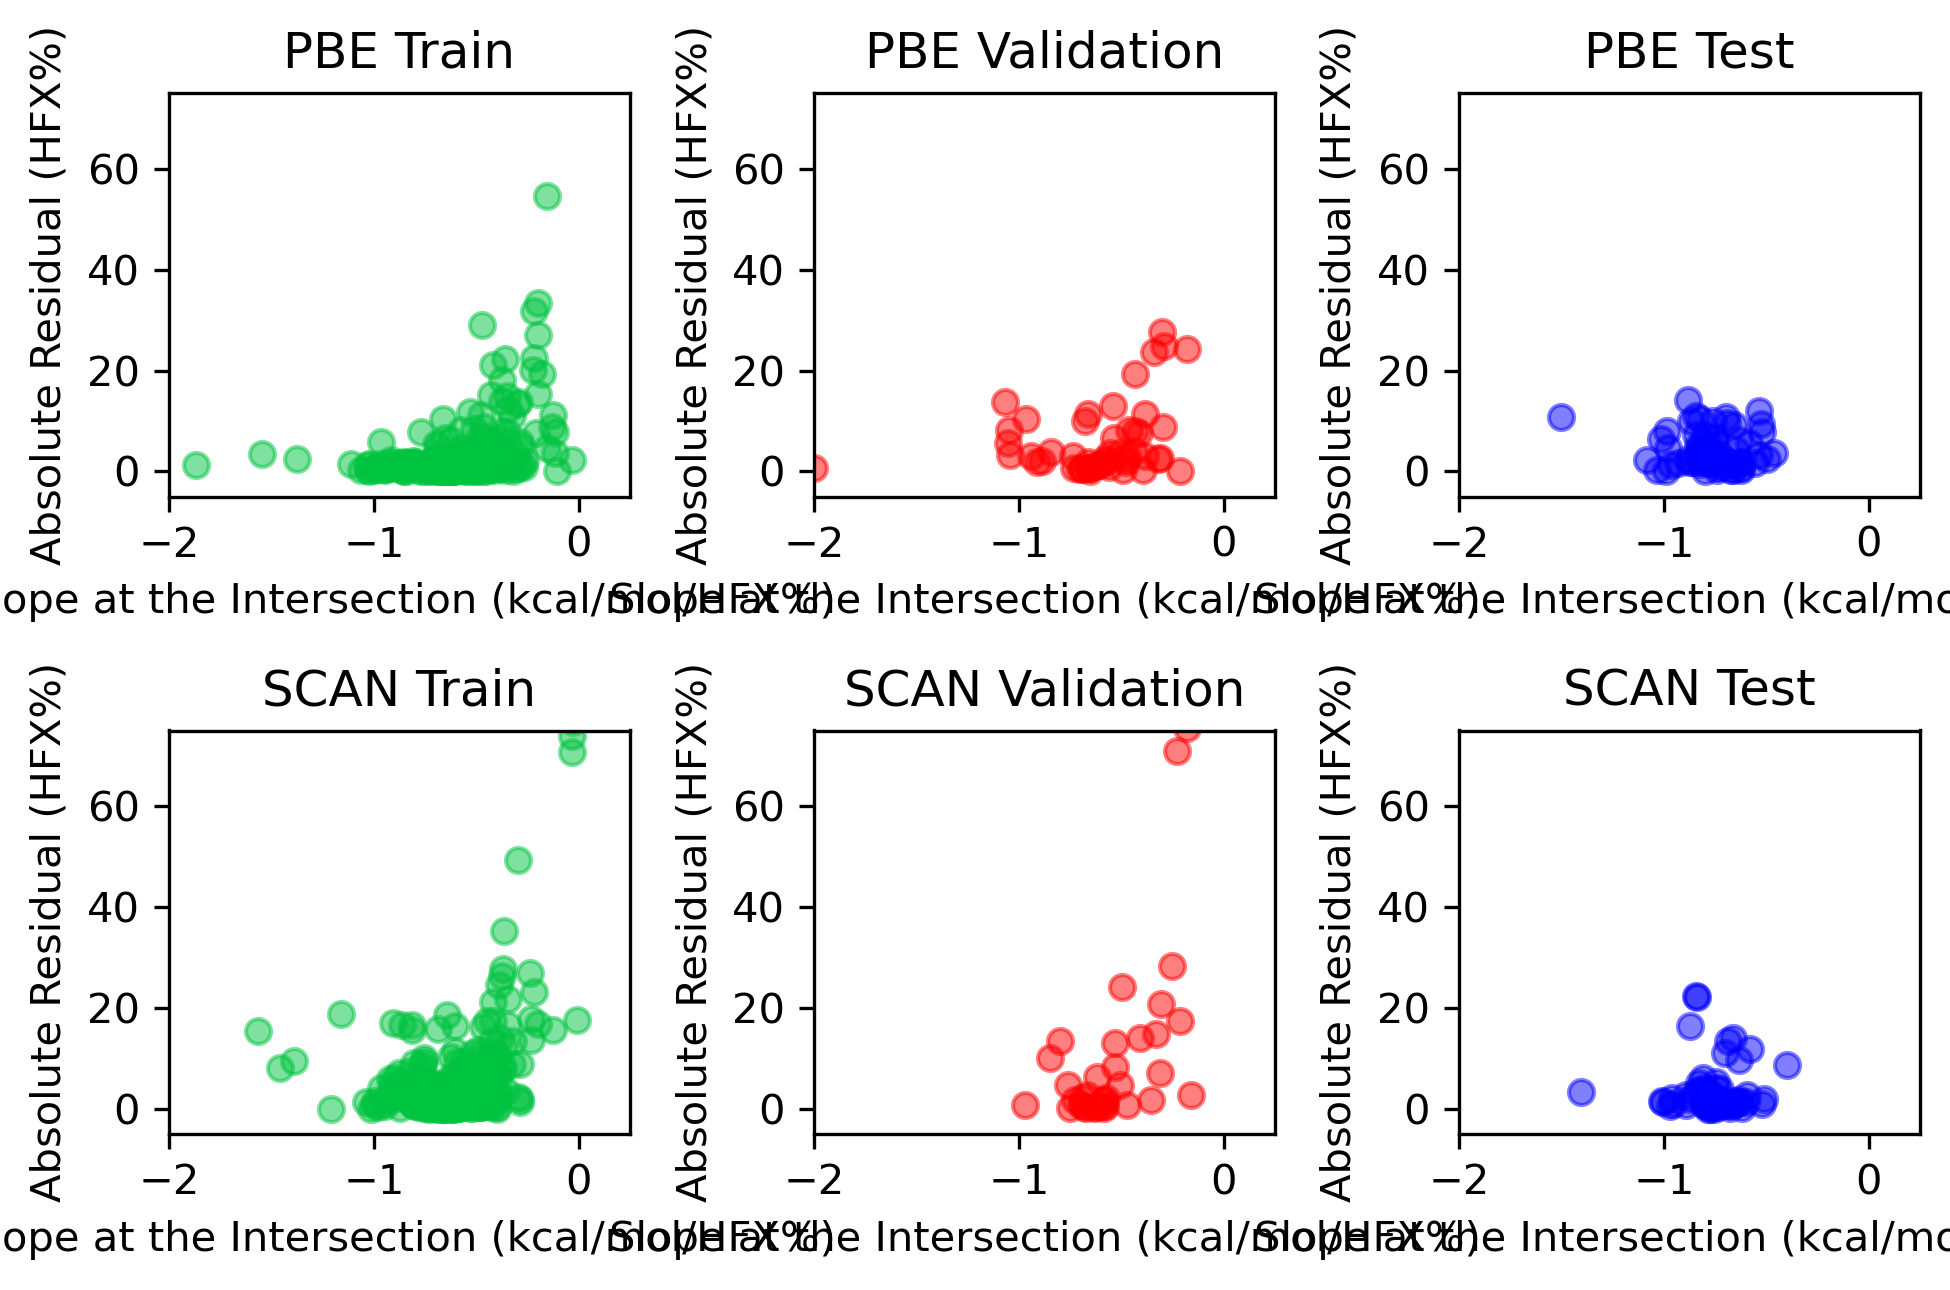

In [10]:
train_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0')
train_df['hfx_err'] = np.nan
train_df['residual'] = np.nan

dataset = 'vss'
df = vss_452
sse_df = vss_sse_df
hfx_df = vss_hfx_df

pbe_errors = []
scan_errors = []

train_df['hfx_err'] = np.abs(train_df['PBE Prediction'] - train_df['PBE Target'])

for struct in train_df.index.to_list():
    dlpno = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
    
    pbe_energy = pred_energy(struct, 'pbe', dataset, train_df)
    if pbe_energy is not None:
        train_df['residual'][struct] = np.abs(dlpno - pbe_energy)
    else:
        train_df['residual'][struct] = np.nan

train_df1 = train_df.join(vss_slopes)

val_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
val_df['hfx_err'] = np.nan
val_df['residual'] = np.nan

dataset = 'vss'
df = vss_452
sse_df = vss_sse_df
hfx_df = vss_hfx_df

pbe_errors = []
scan_errors = []

val_df['hfx_err'] = np.abs(val_df['PBE Prediction'] - val_df['PBE Target'])

for struct in val_df.index.to_list():
    dlpno = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
    
    pbe_energy = pred_energy(struct, 'pbe', dataset, val_df)
    if pbe_energy is not None:
        val_df['residual'][struct] = np.abs(dlpno - pbe_energy)
    else:
        val_df['residual'][struct] = np.nan

val_df1 = val_df.join(vss_slopes)

test_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
test_df['hfx_err'] = np.nan
test_df['residual'] = np.nan

dataset = 'csd'
df = csd_76
sse_df = csd_sse_df
hfx_df = csd_hfx_df

pbe_errors = []
scan_errors = []

test_df['hfx_err'] = np.abs(test_df['PBE Prediction'] - test_df['PBE Target'])

for struct in test_df.index.to_list():
    dlpno = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
    
    pbe_energy = pred_energy(struct, 'pbe', dataset, test_df)
    if pbe_energy is not None:
        test_df['residual'][struct] = np.abs(dlpno - pbe_energy)
    else:
        test_df['residual'][struct] = np.nan

test_df1 = test_df.join(csd_slopes)

train_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0')
train_df['hfx_err'] = np.nan
train_df['residual'] = np.nan

dataset = 'vss'
df = vss_452
sse_df = vss_sse_df
hfx_df = vss_hfx_df

train_df['hfx_err'] = np.abs(train_df['SCAN Prediction'] - train_df['SCAN Target'])

for struct in train_df.index.to_list():
    dlpno = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
    
    scan_energy = pred_energy(struct, 'scan', dataset, train_df)
    if scan_energy is not None:
        train_df['residual'][struct] = np.abs(dlpno - scan_energy)
    else:
        train_df['residual'][struct] = np.nan

train_df2 = train_df.join(vss_slopes)

val_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
val_df['hfx_err'] = np.nan
val_df['residual'] = np.nan

dataset = 'vss'
df = vss_452
sse_df = vss_sse_df
hfx_df = vss_hfx_df

val_df['hfx_err'] = np.abs(val_df['SCAN Prediction'] - val_df['SCAN Target'])

for struct in val_df.index.to_list():
    dlpno = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
    
    scan_energy = pred_energy(struct, 'scan', dataset, val_df)
    if scan_energy is not None:
        val_df['residual'][struct] = np.abs(dlpno - scan_energy)
    else:
        val_df['residual'][struct] = np.nan

val_df2 = val_df.join(vss_slopes)

test_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
test_df['hfx_err'] = np.nan
test_df['residual'] = np.nan

dataset = 'csd'
df = csd_76
sse_df = csd_sse_df
hfx_df = csd_hfx_df

test_df['hfx_err'] = np.abs(test_df['SCAN Prediction'] - test_df['SCAN Target'])

for struct in test_df.index.to_list():
    dlpno = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
    
    scan_energy = pred_energy(struct, 'scan', dataset, test_df)
    if scan_energy is not None:
        test_df['residual'][struct] = np.abs(dlpno - scan_energy)
    else:
        test_df['residual'][struct] = np.nan

test_df2 = test_df.join(csd_slopes)

fig, ax = plt.subplots(ncols=3, nrows=2, dpi=300, figsize=(6.6, 4.4))

ax[0,0].scatter(train_df1['hfx_pbe'], train_df1['hfx_err'], color='#00C440', alpha=0.5)
ax[0,1].scatter(val_df1['hfx_pbe'], val_df1['hfx_err'], color='#FF0000', alpha=0.5)
ax[0,2].scatter(test_df1['hfx_pbe'], test_df1['hfx_err'], color='#0000FF', alpha=0.5)

ax[1,0].scatter(train_df2['hfx_scan'], train_df2['hfx_err'], color='#00C440', alpha=0.5)
ax[1,1].scatter(val_df2['hfx_scan'], val_df2['hfx_err'], color='#FF0000', alpha=0.5)
ax[1,2].scatter(test_df2['hfx_scan'], test_df2['hfx_err'], color='#0000FF', alpha=0.5)

ax[0,0].set_xlim([-2, 0.25])
ax[0,1].set_xlim([-2, 0.25])
ax[0,2].set_xlim([-2, 0.25])
ax[1,0].set_xlim([-2, 0.25])
ax[1,1].set_xlim([-2, 0.25])
ax[1,2].set_xlim([-2, 0.25])

ax[0,0].set_ylim([-5, 75])
ax[0,1].set_ylim([-5, 75])
ax[0,2].set_ylim([-5, 75])
ax[1,0].set_ylim([-5, 75])
ax[1,1].set_ylim([-5, 75])
ax[1,2].set_ylim([-5, 75])

ax[0,0].set_title('PBE Train')
ax[0,1].set_title('PBE Validation')
ax[0,2].set_title('PBE Test')
ax[1,0].set_title('SCAN Train')
ax[1,1].set_title('SCAN Validation')
ax[1,2].set_title('SCAN Test')

ax[0,0].set_xlabel('Slope at the Intersection (kcal/mol/HFX%)', )
ax[0,1].set_xlabel('Slope at the Intersection (kcal/mol/HFX%)')
ax[0,2].set_xlabel('Slope at the Intersection (kcal/mol/HFX%)')
ax[1,0].set_xlabel('Slope at the Intersection (kcal/mol/HFX%)')
ax[1,1].set_xlabel('Slope at the Intersection (kcal/mol/HFX%)')
ax[1,2].set_xlabel('Slope at the Intersection (kcal/mol/HFX%)')

ax[0,0].set_ylabel('Absolute Residual (HFX%)')
ax[0,1].set_ylabel('Absolute Residual (HFX%)')
ax[0,2].set_ylabel('Absolute Residual (HFX%)')
ax[1,0].set_ylabel('Absolute Residual (HFX%)')
ax[1,1].set_ylabel('Absolute Residual (HFX%)')
ax[1,2].set_ylabel('Absolute Residual (HFX%)')

fig.tight_layout()

# Error by Metal Center

In [11]:
metal_df = pd.DataFrame(index=['co_', 'cr_', 'fe_', 'mn_'], columns=['PBE0-train', 'PBE0-val', 'PBE0-test', 'SCAN0-train', 'SCAN0-val', 'SCAN0-test'])
for col in metal_df.columns:
    metal_df[col] = [[],[],[],[]]

for run in trange(6):
    for base_functional in ['PBE0', 'SCAN0']:
        for split in ['train', 'val', 'test']:
            co_errs = []
            cr_errs = []
            fe_errs = []
            mn_errs = []
            
            pred_df = pd.read_csv('DF-BP/' + base_functional.lower() + '_opt' + str(run) + '/BP_predictions_hyperparams-' + split + '.csv')
            pred_df = pred_df.set_index('Unnamed: 0')
    
            if split == 'test':
                dataset = 'csd'
            else:
                dataset = 'vss'
        
            if dataset == 'csd':
                df = csd_76
                sse_df = csd_sse_df
                hfx_df = csd_hfx_df
                metals = ['Co_', 'Cr_', 'Fe_', 'Mn_']
            elif dataset == 'vss':
                df = vss_452
                sse_df = vss_sse_df
                hfx_df = vss_hfx_df
                metals = ['co_', 'cr_', 'fe_', 'mn_']
            
            pbe_errors = []
            scan_errors = []
            
            for struct in pred_df.index.to_list():
                if dataset == 'csd':
                    reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
                elif dataset == 'vss':
                    reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
                else:
                    raise ValueError('Provide a proper reference')
                pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df)
                if pbe_energy is not None and base_functional == 'PBE0':
                    if metals[0] in struct:
                        co_errs.append(reference - pbe_energy)
                    if metals[1] in struct:
                        cr_errs.append(reference - pbe_energy)
                    if metals[2] in struct:
                        fe_errs.append(reference - pbe_energy)
                    if metals[3] in struct:
                        mn_errs.append(reference - pbe_energy)
                scan_energy = pred_energy(struct, 'scan', dataset, pred_df)
                if scan_energy is not None and base_functional == 'SCAN0':
                    if metals[0] in struct:
                        co_errs.append(reference - scan_energy)
                    if metals[1] in struct:
                        cr_errs.append(reference - scan_energy)
                    if metals[2] in struct:
                        fe_errs.append(reference - scan_energy)
                    if metals[3] in struct:
                        mn_errs.append(reference - scan_energy)

            errs = {'co_': co_errs, 'cr_': cr_errs, 'fe_': fe_errs, 'mn_': mn_errs}
            
            for metal in errs:
                if split == 'test' and metal == 'cr_':
                    continue
                else:
                    metal_df[base_functional + '-' + split][metal].extend([np.abs(np.array(errs[metal])).mean()])

metal_df

100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.33s/it]


,PBE0-train,PBE0-val,PBE0-test,SCAN0-train,SCAN0-val,SCAN0-test
co_,"[2.0723347355185897, 2.1050616119298877, 2.304...","[2.1827986259041188, 1.7700466556523509, 3.638...","[5.461374003406954, 5.395393546677144, 6.28462...","[4.083612028363752, 2.4568961496588395, 1.9036...","[1.947115990664444, 7.801249410254068, 2.42362...","[1.6577982607643984, 3.0133557457856956, 6.482..."
cr_,"[4.056669559554701, 4.600092061103329, 4.24514...","[6.910909329895415, 5.652539446902222, 6.46909...",[],"[4.85335919603268, 5.017555894801145, 4.020566...","[4.682688377964918, 4.288366829144396, 4.94315...",[]
fe_,"[0.8955127675719324, 1.0053462612290212, 1.137...","[3.5638905012375663, 4.299218519567768, 3.0409...","[1.9835110162351501, 2.342387861546301, 2.3367...","[1.627981964728247, 1.4060137216179218, 0.7762...","[3.0591799216474347, 3.377378538378508, 3.7505...","[2.5457433121385464, 2.574675568443671, 3.1207..."
mn_,"[1.689482416499352, 1.9613612567631828, 1.6690...","[7.566846201448078, 9.460574195628398, 8.24097...","[5.62286242118236, 1.5064449030347242, 4.89404...","[4.47559797172449, 3.789380799050001, 2.130036...","[2.9898302612834056, 3.2268906292814328, 3.593...","[8.94280779042587, 9.53007043880323, 8.3987352..."


In [12]:
df = metal_df.copy()

for col in df.columns:
    df[col] = df[col].apply(lambda x: np.mean(np.array(x)))

df

/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,PBE0-train,PBE0-val,PBE0-test,SCAN0-train,SCAN0-val,SCAN0-test
co_,2.12,2.08,5.14,3.16,3.16,3.02
cr_,4.30,6.78,NaN,4.77,4.53,NaN
fe_,0.99,3.32,2.32,1.42,3.03,2.52
mn_,1.78,8.26,3.91,3.66,4.26,8.76


In [13]:
df = metal_df.copy()

for col in df.columns:
    df[col] = df[col].apply(lambda x: np.std(np.array(x)))

df

/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,PBE0-train,PBE0-val,PBE0-test,SCAN0-train,SCAN0-val,SCAN0-test
co_,0.13,0.96,0.78,0.78,2.25,1.66
cr_,0.37,1.32,NaN,0.36,0.31,NaN
fe_,0.13,0.61,0.24,0.31,0.54,0.36
mn_,0.34,0.85,1.58,0.79,1.30,0.55


In [14]:
# t test comparing subsets to complement set, PBE0

from scipy.stats import shapiro, ttest_ind

train_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0').sort_index()
train_df['PBE Residual'] = np.abs(train_df['PBE Target'] - train_df['PBE Prediction'])
train_df = train_df.dropna(subset=['PBE Residual'])

val_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0').sort_index()
val_df['PBE Residual'] = np.abs(val_df['PBE Target'] - val_df['PBE Prediction'])
val_df = val_df.dropna(subset=['PBE Residual'])

test_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0').sort_index()
test_df['PBE Residual'] = np.abs(test_df['PBE Target'] - test_df['PBE Prediction'])
test_df = test_df.dropna(subset=['PBE Residual'])

for split in ['train', 'val', 'test']:
    if split == 'train':
        df = train_df
        all_metals = ['co', 'cr', 'fe', 'mn']
    elif split == 'val':
        df = val_df
        all_metals = ['co', 'cr', 'fe', 'mn']
    else:
        df = test_df
        all_metals = ['Co', 'Cr', 'Fe', 'Mn']
    print('==========================')
    for metal in all_metals:
        print(f'There are {len(df)} structures in {split}.')
        df1 = df[[metal in x for x in df.index]]
        print(f'There are {len(df1)} ({len(df1)/len(df)*100:1.1f}%) structures containing {metal}.')
        print(f'The MAE of the subset of metal {metal} is {df1["PBE Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1["PBE Residual"])}.')
        df1_complement = df[[metal not in x for x in df.index]]
        print(f'There are {len(df1_complement)} ({len(df1_complement)/len(df)*100:1.1f}%) structures not containing {metal}.')
        print(f'The MAE of the complement of subset of metal {metal} is {df1_complement["PBE Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1_complement["PBE Residual"])}.')
        outliers = df.sort_values('PBE Residual', ascending=False).head(int(0.2*len(df)))
        #print(f'There are {len(outliers)} structures in the top 20%.')
        df2 = outliers[[metal in x for x in outliers.index]]
        print(f'There are {len(df2)} ({len(df2)/len(outliers)*100:1.1f}%) outliers containing {metal}.')
        print(f'The t-test between the two populations yields {ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative="greater", equal_var=False)}.')
        if ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative='greater', equal_var=False).pvalue < 0.05:
            print('STATISTICALLY SIGNIFICANT\n')
        else:
            print('\n')

There are 297 structures in train.
There are 60 (20.2%) structures containing co.
The MAE of the subset of metal co is 3.64 HFX%.
There are 237 (79.8%) structures not containing co.
The MAE of the complement of subset of metal co is 2.99 HFX%.
There are 11 (18.6%) outliers containing co.
The t-test between the two populations yields Ttest_indResult(statistic=0.5999747228769626, pvalue=0.2752018286351051).


There are 297 structures in train.
There are 52 (17.5%) structures containing cr.
The MAE of the subset of metal cr is 7.66 HFX%.
There are 245 (82.5%) structures not containing cr.
The MAE of the complement of subset of metal cr is 2.16 HFX%.
There are 30 (50.8%) outliers containing cr.
The t-test between the two populations yields Ttest_indResult(statistic=4.551978714764237, pvalue=1.3964467853783337e-05).
STATISTICALLY SIGNIFICANT

There are 297 structures in train.
There are 128 (43.1%) structures containing fe.
The MAE of the subset of metal fe is 1.22 HFX%.
There are 169 (56.9

In [15]:
# t test comparing subsets to complement set, SCAN)

from scipy.stats import shapiro, ttest_ind

train_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0').sort_index()
train_df['SCAN Residual'] = np.abs(train_df['SCAN Target'] - train_df['SCAN Prediction'])
train_df = train_df.dropna(subset=['SCAN Residual'])

val_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0').sort_index()
val_df['SCAN Residual'] = np.abs(val_df['SCAN Target'] - val_df['SCAN Prediction'])
val_df = val_df.dropna(subset=['SCAN Residual'])

test_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0').sort_index()
test_df['SCAN Residual'] = np.abs(test_df['SCAN Target'] - test_df['SCAN Prediction'])
test_df = test_df.dropna(subset=['SCAN Residual'])

for split in ['train', 'val', 'test']:
    if split == 'train':
        df = train_df
        all_metals = ['co', 'cr', 'fe', 'mn']
    elif split == 'val':
        df = val_df
        all_metals = ['co', 'cr', 'fe', 'mn']
    else:
        df = test_df
        all_metals = ['Co', 'Cr', 'Fe', 'Mn']
    print('==========================')
    for metal in all_metals:
        print(f'There are {len(df)} structures in {split}.')
        df1 = df[[metal in x for x in df.index]]
        print(f'There are {len(df1)} ({len(df1)/len(df)*100:1.1f}%) structures containing {metal}.')
        print(f'The MAE of the subset of metal {metal} is {df1["SCAN Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1["PBE Residual"])}.')
        df1_complement = df[[metal not in x for x in df.index]]
        print(f'There are {len(df1_complement)} ({len(df1_complement)/len(df)*100:1.1f}%) structures not containing {metal}.')
        print(f'The MAE of the complement of subset of metal {metal} is {df1_complement["SCAN Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1_complement["PBE Residual"])}.')
        outliers = df.sort_values('SCAN Residual', ascending=False).head(int(0.2*len(df)))
        #print(f'There are {len(outliers)} structures in the top 20%.')
        df2 = outliers[[metal in x for x in outliers.index]]
        print(f'There are {len(df2)} ({len(df2)/len(outliers)*100:1.1f}%) outliers containing {metal}.')
        print(f'The t-test between the two populations yields {ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative="greater", equal_var=False)}.')
        if ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative='greater', equal_var=False).pvalue < 0.05:
            print('STATISTICALLY SIGNIFICANT\n')
        else:
            print('\n')

There are 285 structures in train.
There are 60 (21.1%) structures containing co.
The MAE of the subset of metal co is 4.80 HFX%.
There are 225 (78.9%) structures not containing co.
The MAE of the complement of subset of metal co is 5.79 HFX%.
There are 11 (19.3%) outliers containing co.
The t-test between the two populations yields Ttest_indResult(statistic=-0.8694156104446521, pvalue=0.8068806806219944).


There are 285 structures in train.
There are 46 (16.1%) structures containing cr.
The MAE of the subset of metal cr is 13.66 HFX%.
There are 239 (83.9%) structures not containing cr.
The MAE of the complement of subset of metal cr is 4.02 HFX%.
There are 21 (36.8%) outliers containing cr.
The t-test between the two populations yields Ttest_indResult(statistic=3.7003389541915315, pvalue=0.0002817473829786058).
STATISTICALLY SIGNIFICANT

There are 285 structures in train.
There are 129 (45.3%) structures containing fe.
The MAE of the subset of metal fe is 2.36 HFX%.
There are 156 (54

# Errors by Ligand Type in VSS-452-HFX

In [16]:
#PBE0

all_lig = []

for struct in train_df.index:
    ligands = struct.split('_')[2:-1]
    for ligand in ligands:
        all_lig.append(ligand.split('-')[0])

all_lig = sorted(set(all_lig))

train_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0').sort_index()
train_df['PBE Residual'] = np.abs(train_df['PBE Target'] - train_df['PBE Prediction'])
train_df = train_df.dropna(subset=['PBE Residual'])

val_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0').sort_index()
val_df['PBE Residual'] = np.abs(val_df['PBE Target'] - val_df['PBE Prediction'])
val_df = val_df.dropna(subset=['PBE Residual'])

for split in ['train', 'val']:
    if split == 'train':
        df = train_df
    else:
        df = val_df
    print('==========================')
    for lig in all_lig:
        print(f'There are {len(df)} structures in {split}.')
        df1 = df[[lig in x for x in df.index]]
        print(f'There are {len(df1)} ({len(df1)/len(df)*100:1.1f}%) structures containing {lig}.')
        print(f'The MAE of the subset of ligand {lig} is {df1["PBE Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1["PBE Residual"])}.')
        df1_complement = df[[lig not in x for x in df.index]]
        print(f'There are {len(df1_complement)} ({len(df1_complement)/len(df)*100:1.1f}%) structures not containing {lig}.')
        print(f'The MAE of the complement of subset of ligand {lig} is {df1_complement["PBE Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1_complement["PBE Residual"])}.')
        outliers = df.sort_values('PBE Residual', ascending=False).head(int(0.2*len(df)))
        #print(f'There are {len(outliers)} structures in the top 20%.')
        df2 = outliers[[lig in x for x in outliers.index]]
        print(f'There are {len(df2)} ({len(df2)/len(outliers)*100:1.1f}%) outliers containing {lig}.')
        print(f'The t-test between the two populations yields {ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative="greater", equal_var=False)}.')
        if ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative="greater", equal_var=False).pvalue < 0.05:
            print('STATISTICALLY SIGNIFICANT\n')
        else:
            print('\n')

There are 297 structures in train.
There are 35 (11.8%) structures containing SH2.
The MAE of the subset of ligand SH2 is 2.43 HFX%.
There are 262 (88.2%) structures not containing SH2.
The MAE of the complement of subset of ligand SH2 is 3.22 HFX%.
There are 9 (15.3%) outliers containing SH2.
The t-test between the two populations yields Ttest_indResult(statistic=-1.4483082801468952, pvalue=0.9249038367241734).


There are 297 structures in train.
There are 37 (12.5%) structures containing acetonitrile.
The MAE of the subset of ligand acetonitrile is 2.42 HFX%.
There are 260 (87.5%) structures not containing acetonitrile.
The MAE of the complement of subset of ligand acetonitrile is 3.22 HFX%.
There are 4 (6.8%) outliers containing acetonitrile.
The t-test between the two populations yields Ttest_indResult(statistic=-0.9019017074509922, pvalue=0.814385456721144).


There are 297 structures in train.
There are 7 (2.4%) structures containing amine.
The MAE of the subset of ligand amine 

/tmp/ipykernel_991301/1862173311.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(f'The t-test between the two populations yields {ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative="greater", equal_var=False)}.')
/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_991301/1862173311.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Result

In [17]:
#SCAN0

all_lig = []

for struct in train_df.index:
    ligands = struct.split('_')[2:-1]
    for ligand in ligands:
        all_lig.append(ligand.split('-')[0])

all_lig = sorted(set(all_lig))

train_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-train.csv').set_index('Unnamed: 0').sort_index()
train_df['SCAN Residual'] = np.abs(train_df['SCAN Target'] - train_df['SCAN Prediction'])
train_df = train_df.dropna(subset=['SCAN Residual'])

val_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0').sort_index()
val_df['SCAN Residual'] = np.abs(val_df['SCAN Target'] - val_df['SCAN Prediction'])
val_df = val_df.dropna(subset=['SCAN Residual'])

for split in ['train', 'val']:
    if split == 'train':
        df = train_df
    else:
        df = val_df
    print('==========================')
    for lig in all_lig:
        print(f'There are {len(df)} structures in {split}.')
        df1 = df[[lig in x for x in df.index]]
        print(f'There are {len(df1)} ({len(df1)/len(df)*100:1.1f}%) structures containing {lig}.')
        print(f'The MAE of the subset of ligand {lig} is {df1["SCAN Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1["PBE Residual"])}.')
        df1_complement = df[[lig not in x for x in df.index]]
        print(f'There are {len(df1_complement)} ({len(df1_complement)/len(df)*100:1.1f}%) structures not containing {lig}.')
        print(f'The MAE of the complement of subset of ligand {lig} is {df1_complement["SCAN Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1_complement["PBE Residual"])}.')
        outliers = df.sort_values('SCAN Residual', ascending=False).head(int(0.2*len(df)))
        #print(f'There are {len(outliers)} structures in the top 20%.')
        df2 = outliers[[lig in x for x in outliers.index]]
        print(f'There are {len(df2)} ({len(df2)/len(outliers)*100:1.1f}%) outliers containing {lig}.')
        print(f'The t-test between the two populations yields {ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative="greater", equal_var=False)}.')
        if ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative="greater", equal_var=False).pvalue < 0.05:
            print('STATISTICALLY SIGNIFICANT\n')
        else:
            print('\n')

There are 285 structures in train.
There are 34 (11.9%) structures containing SH2.
The MAE of the subset of ligand SH2 is 7.52 HFX%.
There are 251 (88.1%) structures not containing SH2.
The MAE of the complement of subset of ligand SH2 is 5.32 HFX%.
There are 8 (14.0%) outliers containing SH2.
The t-test between the two populations yields Ttest_indResult(statistic=0.851920699977636, pvalue=0.19994024391432286).


There are 285 structures in train.
There are 33 (11.6%) structures containing acetonitrile.
The MAE of the subset of ligand acetonitrile is 3.72 HFX%.
There are 252 (88.4%) structures not containing acetonitrile.
The MAE of the complement of subset of ligand acetonitrile is 5.82 HFX%.
There are 4 (7.0%) outliers containing acetonitrile.
The t-test between the two populations yields Ttest_indResult(statistic=-2.171965228705519, pvalue=0.9837431195924798).


There are 285 structures in train.
There are 7 (2.5%) structures containing amine.
The MAE of the subset of ligand amine i

/tmp/ipykernel_991301/2475593188.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(f'The t-test between the two populations yields {ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative="greater", equal_var=False)}.')


There are 3 (5.3%) outliers containing carboxyl.
The t-test between the two populations yields Ttest_indResult(statistic=0.7460676564288377, pvalue=0.23782513181302606).


There are 285 structures in train.
There are 23 (8.1%) structures containing chloride.
The MAE of the subset of ligand chloride is 7.31 HFX%.
There are 262 (91.9%) structures not containing chloride.
The MAE of the complement of subset of ligand chloride is 5.43 HFX%.
There are 4 (7.0%) outliers containing chloride.
The t-test between the two populations yields Ttest_indResult(statistic=0.60204167173943, pvalue=0.27646231811611144).


There are 285 structures in train.
There are 50 (17.5%) structures containing cs.
The MAE of the subset of ligand cs is 3.89 HFX%.
There are 235 (82.5%) structures not containing cs.
The MAE of the complement of subset of ligand cs is 5.94 HFX%.
There are 6 (10.5%) outliers containing cs.
The t-test between the two populations yields Ttest_indResult(statistic=-2.0448274282824737, pvalue

/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_991301/2475593188.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  if ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative="greater", equal_var=False).pvalue < 0.05:


# Outliers in CSD-76-HFX

In [18]:
#find outliers

b3lyp_test = pd.read_csv('DF-BP/b3lyp_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
b3lyp_test['b3lyp_pbe_residual'] = b3lyp_test['PBE Target'] - b3lyp_test['PBE Prediction']
b3lyp_test['b3lyp_scan_residual'] = b3lyp_test['SCAN Target'] - b3lyp_test['SCAN Prediction']
b3lyp_test = b3lyp_test.drop(columns=['PBE Target', 'PBE Prediction', 'SCAN Target', 'SCAN Prediction'])

pbe0_test = pd.read_csv('DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
pbe0_test['pbe0_pbe_residual'] = pbe0_test['PBE Target'] - pbe0_test['PBE Prediction']
pbe0_test['pbe0_scan_residual'] = pbe0_test['SCAN Target'] - pbe0_test['SCAN Prediction']
pbe0_test = pbe0_test.drop(columns=['PBE Target', 'PBE Prediction', 'SCAN Target', 'SCAN Prediction'])

scan0_test = pd.read_csv('DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
scan0_test['scan0_pbe_residual'] = scan0_test['PBE Target'] - scan0_test['PBE Prediction']
scan0_test['scan0_scan_residual'] = scan0_test['SCAN Target'] - scan0_test['SCAN Prediction']
scan0_test = scan0_test.drop(columns=['PBE Target', 'PBE Prediction', 'SCAN Target', 'SCAN Prediction'])

tot_df = pd.concat([b3lyp_test, pbe0_test, scan0_test], axis=1)

for idx, row in tot_df.iterrows():
    if np.any(np.abs(row.values) > 15):
        print(row)

b3lyp_pbe_residual    -21.34
b3lyp_scan_residual    -4.32
pbe0_pbe_residual      -1.28
pbe0_scan_residual      3.78
scan0_pbe_residual      6.20
scan0_scan_residual    -1.62
Name: Co_ILASAR_comp_0_51, dtype: float64
b3lyp_pbe_residual     26.54
b3lyp_scan_residual    18.73
pbe0_pbe_residual      10.03
pbe0_scan_residual    -38.52
scan0_pbe_residual     24.36
scan0_scan_residual    22.46
Name: Mn_MEDHOS_comp_0_3111, dtype: float64
b3lyp_pbe_residual    20.89
b3lyp_scan_residual   21.92
pbe0_pbe_residual      4.75
pbe0_scan_residual     4.75
scan0_pbe_residual    -3.57
scan0_scan_residual   14.13
Name: Fe_VOBHUP_comp_0_2211, dtype: float64
b3lyp_pbe_residual     13.74
b3lyp_scan_residual    11.76
pbe0_pbe_residual       3.60
pbe0_scan_residual    -27.55
scan0_pbe_residual     20.54
scan0_scan_residual    22.21
Name: Mn_LEZMEK_comp_1_111111, dtype: float64
b3lyp_pbe_residual     -3.34
b3lyp_scan_residual   -10.40
pbe0_pbe_residual      -6.33
pbe0_scan_residual     -7.57
scan0_pbe_residual

# Errors by Denticity

In [19]:
#get different denticity combinations in CSD-76

csd_structs = pd.read_csv('DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv')['Unnamed: 0'].to_list()
ligtypes = set([x.split('_')[-1] for x in csd_structs])
d = {x: 0 for x in ligtypes}
for struct in csd_structs:
    d[struct.split('_')[-1]] += 1

d

{'51': 2,
 '21111': 2,
 '3111': 4,
 '6': 3,
 '411': 6,
 '111111': 23,
 '2211': 4,
 '33': 9,
 '222': 5,
 '42': 2,
 '321': 3}

In [20]:
lig_df = pd.DataFrame(index=ligtypes, columns=['PBE0', 'SCAN0'])
for col in lig_df.columns:
    lig_df[col] = [[],[],[],[], [], [], [], [], [], [], []]

for run in trange(6):
    for base_functional in ['PBE0', 'SCAN0']:
        d = {x: [] for x in ligtypes}
            
        pred_df = pd.read_csv('DF-BP/' + base_functional.lower() + '_opt' + str(run) + '/BP_predictions_hyperparams-test.csv')
        pred_df = pred_df.set_index('Unnamed: 0')

        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
        
        pbe_errors = []
        scan_errors = []
        
        for struct in pred_df.index.to_list():
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
            
            pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df)
            if pbe_energy is not None and base_functional == 'PBE0':
                d[struct.split('_')[-1]].append(reference - pbe_energy)
            scan_energy = pred_energy(struct, 'scan', dataset, pred_df)
            if scan_energy is not None and base_functional == 'SCAN0':
                d[struct.split('_')[-1]].append(reference - scan_energy)
        
        for lig in d:
            lig_df[base_functional][lig].extend([np.abs(np.array(d[lig])).mean()])

lig_df

100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


,PBE0,SCAN0
51,"[1.9577697260314642, 1.3612657862467414, 5.274...","[1.341902576652636, 4.312202354974721, 8.68663..."
21111,"[5.610007010883205, 5.211841382100401, 7.44788...","[8.287908028701036, 8.724120714312727, 5.83098..."
3111,"[4.571896056985541, 3.549379639955576, 7.33584...","[6.834898980554436, 7.841988559964094, 12.1946..."
6,"[2.950450671617413, 2.822299535805996, 3.30352...","[2.5855790373536003, 2.1209833562160227, 5.689..."
411,"[3.793922279519497, 3.7358891291287164, 5.0355...","[2.128371069815618, 2.9201664828269496, 5.9665..."
111111,"[2.190888203827937, 1.4438039642282456, 1.7351...","[2.6880688823836523, 2.6280120217767005, 1.728..."
2211,"[5.783215374409762, 6.646645083622701, 6.57228...","[3.6858137258416006, 3.6392250433157614, 7.602..."
33,"[1.547607177003999, 1.8964784650516218, 1.8327...","[1.3129400797019504, 1.6538027089715415, 3.872..."
222,"[5.806090855392448, 6.279189418480999, 5.75861...","[2.5469538208860643, 5.991166164814419, 6.1836..."
42,"[1.2128801037437977, 0.11109422879803788, 0.56...","[1.9582071871933193, 1.5161694710776885, 2.607..."


In [21]:
df = lig_df.copy()

for col in df.columns:
    df[col] = df[col].apply(lambda x: np.mean(np.array(x)))

df.sort_index()

,PBE0,SCAN0
111111,1.66,2.36
21111,5.63,7.40
2211,5.87,4.06
222,5.33,3.70
3111,5.38,8.12
321,7.72,4.20
33,2.16,2.08
411,3.91,3.25
42,0.62,2.21
51,2.59,3.50


In [22]:
df = lig_df.copy()

for col in df.columns:
    df[col] = df[col].apply(lambda x: np.std(np.array(x)))

df.sort_index()

,PBE0,SCAN0
111111,0.29,0.34
21111,1.24,1.03
2211,1.00,1.71
222,0.70,1.70
3111,1.44,1.90
321,1.09,2.86
33,0.68,0.91
411,0.51,1.30
42,0.56,1.09
51,1.37,2.54


In [23]:
#PBE0

all_lig = []

test_df = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0').sort_index()
test_df['PBE Residual'] = np.abs(test_df['PBE Target'] - test_df['PBE Prediction'])
test_df = test_df.dropna(subset=['PBE Residual'])

for struct in test_df.index:
    ligand = struct.split('_')[-1]
    all_lig.append(ligand)

all_lig = sorted(set(all_lig))

for split in ['test']:
    df = test_df
    print('==========================')
    for lig in all_lig:
        print(f'There are {len(df)} structures in {split}.')
        df1 = df[[lig in x for x in df.index]]
        print(f'There are {len(df1)} ({len(df1)/len(df)*100:1.1f}%) structures containing {lig}.')
        print(f'The MAE of the subset of ligand {lig} is {df1["PBE Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1["PBE Residual"])}.')
        df1_complement = df[[lig not in x for x in df.index]]
        print(f'There are {len(df1_complement)} ({len(df1_complement)/len(df)*100:1.1f}%) structures not containing {lig}.')
        print(f'The MAE of the complement of subset of ligand {lig} is {df1_complement["PBE Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1_complement["PBE Residual"])}.')
        outliers = df.sort_values('PBE Residual', ascending=False).head(int(0.2*len(df)))
        #print(f'There are {len(outliers)} structures in the top 20%.')
        df2 = outliers[[lig in x for x in outliers.index]]
        print(f'There are {len(df2)} ({len(df2)/len(outliers)*100:1.1f}%) outliers containing {lig}.')
        print(f'The t-test between the two populations yields {ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative="greater", equal_var=False)}.')
        if ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative="greater", equal_var=False).pvalue < 0.05:
            print('STATISTICALLY SIGNIFICANT\n')
        else:
            print('\n')


There are 65 structures in test.
There are 24 (36.9%) structures containing 111111.
The MAE of the subset of ligand 111111 is 2.63 HFX%.
There are 41 (63.1%) structures not containing 111111.
The MAE of the complement of subset of ligand 111111 is 5.38 HFX%.
There are 2 (15.4%) outliers containing 111111.
The t-test between the two populations yields Ttest_indResult(statistic=-3.5007120643761427, pvalue=0.9995579570504805).


There are 65 structures in test.
There are 2 (3.1%) structures containing 21111.
The MAE of the subset of ligand 21111 is 4.32 HFX%.
There are 63 (96.9%) structures not containing 21111.
The MAE of the complement of subset of ligand 21111 is 4.36 HFX%.
There are 0 (0.0%) outliers containing 21111.
The t-test between the two populations yields Ttest_indResult(statistic=-0.022041911739437477, pvalue=0.5071452887713136).


There are 65 structures in test.
There are 5 (7.7%) structures containing 2211.
The MAE of the subset of ligand 2211 is 7.78 HFX%.
There are 60 (9

/tmp/ipykernel_991301/548950086.py:32: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(f'The t-test between the two populations yields {ttest_ind(df1["PBE Residual"], df1_complement["PBE Residual"], alternative="greater", equal_var=False)}.')
/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/aaron_g/.conda/envs/dfa_rec/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/tmp/ipykernel_991301/548950086.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results 

In [24]:
#SCAN0

all_lig = []

test_df = pd.read_csv('../ml_training/DF-BP/scan0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0').sort_index()
test_df['SCAN Residual'] = np.abs(test_df['SCAN Target'] - test_df['SCAN Prediction'])
test_df = test_df.dropna(subset=['SCAN Residual'])

for struct in test_df.index:
    ligand = struct.split('_')[-1]
    all_lig.append(ligand)

all_lig = sorted(set(all_lig))

for split in ['test']:
    df = test_df
    print('==========================')
    for lig in all_lig:
        print(f'There are {len(df)} structures in {split}.')
        df1 = df[[lig in x for x in df.index]]
        print(f'There are {len(df1)} ({len(df1)/len(df)*100:1.1f}%) structures containing {lig}.')
        print(f'The MAE of the subset of ligand {lig} is {df1["SCAN Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1["PBE Residual"])}.')
        df1_complement = df[[lig not in x for x in df.index]]
        print(f'There are {len(df1_complement)} ({len(df1_complement)/len(df)*100:1.1f}%) structures not containing {lig}.')
        print(f'The MAE of the complement of subset of ligand {lig} is {df1_complement["SCAN Residual"].mean():1.2f} HFX%.')
        #print(f'The Shapiro-Wilk p-value is {shapiro(df1_complement["PBE Residual"])}.')
        outliers = df.sort_values('SCAN Residual', ascending=False).head(int(0.2*len(df)))
        #print(f'There are {len(outliers)} structures in the top 20%.')
        df2 = outliers[[lig in x for x in outliers.index]]
        print(f'There are {len(df2)} ({len(df2)/len(outliers)*100:1.1f}%) outliers containing {lig}.')
        print(f'The t-test between the two populations yields {ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative="greater", equal_var=False)}.')
        if ttest_ind(df1["SCAN Residual"], df1_complement["SCAN Residual"], alternative="greater", equal_var=False).pvalue < 0.05:
            print('STATISTICALLY SIGNIFICANT\n')
        else:
            print('\n')


There are 63 structures in test.
There are 23 (36.5%) structures containing 111111.
The MAE of the subset of ligand 111111 is 3.36 HFX%.
There are 40 (63.5%) structures not containing 111111.
The MAE of the complement of subset of ligand 111111 is 3.76 HFX%.
There are 4 (33.3%) outliers containing 111111.
The t-test between the two populations yields Ttest_indResult(statistic=-0.2986071221889387, pvalue=0.616655570278767).


There are 63 structures in test.
There are 2 (3.2%) structures containing 21111.
The MAE of the subset of ligand 21111 is 9.36 HFX%.
There are 61 (96.8%) structures not containing 21111.
The MAE of the complement of subset of ligand 21111 is 3.42 HFX%.
There are 1 (8.3%) outliers containing 21111.
The t-test between the two populations yields Ttest_indResult(statistic=0.8309148212377204, pvalue=0.2784844235989486).


There are 63 structures in test.
There are 4 (6.3%) structures containing 2211.
The MAE of the subset of ligand 2211 is 6.97 HFX%.
There are 59 (93.7%

# DFA Recommender Comparisons

In [25]:
#get train/val/test sizes when comparing to DFA recommender

pbe0_train = pd.read_csv('DF-BP/pbe0_opt-dfarec/BP_predictions_hyperparams-train.csv')
pbe0_val = pd.read_csv('DF-BP/pbe0_opt-dfarec/BP_predictions_hyperparams-val.csv')
pbe0_test = pd.read_csv('DF-BP/pbe0_opt-dfarec/BP_predictions_hyperparams-test.csv')
print(f'The training/validation/test sizes for PBE0 PBEx are {len(pbe0_train["PBE Prediction"].dropna())}/{len(pbe0_val["PBE Prediction"].dropna())}/{len(pbe0_test["PBE Prediction"].dropna())}.')
print(f'The training/validation/test sizes for PBE0 SCANx are {len(pbe0_train["SCAN Prediction"].dropna())}/{len(pbe0_val["SCAN Prediction"].dropna())}/{len(pbe0_test["SCAN Prediction"].dropna())}.')

scan0_train = pd.read_csv('DF-BP/scan0_opt-dfarec/BP_predictions_hyperparams-train.csv')
scan0_val = pd.read_csv('DF-BP/scan0_opt-dfarec/BP_predictions_hyperparams-val.csv')
scan0_test = pd.read_csv('DF-BP/scan0_opt-dfarec/BP_predictions_hyperparams-test.csv')
print(f'The training/validation/test sizes for SCAN0 PBEx are {len(scan0_train["PBE Prediction"].dropna())}/{len(scan0_val["PBE Prediction"].dropna())}/{len(scan0_test["PBE Prediction"].dropna())}.')
print(f'The training/validation/test sizes for SCAN0 SCANx are {len(scan0_train["SCAN Prediction"].dropna())}/{len(scan0_val["SCAN Prediction"].dropna())}/{len(scan0_test["SCAN Prediction"].dropna())}.')

The training/validation/test sizes for PBE0 PBEx are 230/118/65.
The training/validation/test sizes for PBE0 SCANx are 216/115/63.
The training/validation/test sizes for SCAN0 PBEx are 208/112/63.
The training/validation/test sizes for SCAN0 SCANx are 209/111/63.


In [26]:
#compare to DFA recommender; mean energy

energy_df = pd.DataFrame(index=['dfarec'], columns=['train-pbe_err', 'val-pbe_err', 'test-pbe_err', 'train-scan_err', 'val-scan_err', 'test-scan_err'])

base_functional = 'scan0' #'b3lyp', 'pbe0', 'scan0'

for split in ['train', 'val', 'test']:
    pred_df = pd.read_csv('DF-BP/' + base_functional + '_opt-dfarec/BP_predictions_hyperparams-' + split + '.csv')
    pred_df = pred_df.set_index('Unnamed: 0')

    if split == 'test':
        dataset = 'csd'
    else:
        dataset = 'vss'

    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    
    pbe_errors = []
    scan_errors = []
    
    for struct in pred_df.index.to_list():
        if dataset == 'csd':
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset, pred_df)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)
    
    len(pbe_errors), len(scan_errors)
    energy_df[split + '-pbe_err']['dfarec'] = np.mean(np.abs(np.array(pbe_errors)))
    energy_df[split + '-scan_err']['dfarec'] = np.mean(np.abs(np.array(scan_errors)))

energy_df

,train-pbe_err,val-pbe_err,test-pbe_err,train-scan_err,val-scan_err,test-scan_err
dfarec,1.96,3.43,3.32,1.30,3.02,4.28


In [27]:
#compare to DFA recommender; median energy

energy_df = pd.DataFrame(index=['dfarec'], columns=['train-pbe_err', 'val-pbe_err', 'test-pbe_err', 'train-scan_err', 'val-scan_err', 'test-scan_err'])

base_functional = 'pbe0' #'b3lyp', 'pbe0', 'scan0'

for split in ['train', 'val', 'test']:
    pred_df = pd.read_csv('DF-BP/' + base_functional + '_opt-dfarec/BP_predictions_hyperparams-' + split + '.csv')
    pred_df = pred_df.set_index('Unnamed: 0')

    if split == 'test':
        dataset = 'csd'
    else:
        dataset = 'vss'

    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    
    pbe_errors = []
    scan_errors = []
    
    for struct in pred_df.index.to_list():
        if dataset == 'csd':
            reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        elif dataset == 'vss':
            reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
        else:
            raise ValueError('Provide a proper reference')
        pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', dataset, pred_df)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)
    
    len(pbe_errors), len(scan_errors)
    energy_df[split + '-pbe_err']['dfarec'] = np.median(np.abs(np.array(pbe_errors)))
    energy_df[split + '-scan_err']['dfarec'] = np.median(np.abs(np.array(scan_errors)))

energy_df

,train-pbe_err,val-pbe_err,test-pbe_err,train-scan_err,val-scan_err,test-scan_err
dfarec,0.82,1.38,2.28,0.50,1.37,2.44


In [28]:
#compare to DFA recommender, HFX%

runs = [str(x) for x in np.arange(0, 6)]
energy_df = pd.DataFrame(index=['dfarec'], columns=['train-pbe_err', 'val-pbe_err', 'test-pbe_err', 'train-scan_err', 'val-scan_err', 'test-scan_err'])
base_functional = 'scan0' #'b3lyp', 'pbe0', 'scan0'

for run in ['dfarec']:
    for split in ['train', 'val', 'test']:
        pred_df = pd.read_csv('DF-BP/' + base_functional + '_opt-' + str(run) + '/BP_predictions_hyperparams-' + split + '.csv')
        pred_df = pred_df.set_index('Unnamed: 0')
        
        pbe_errors = (pred_df['PBE Target'] - pred_df['PBE Prediction']).dropna()
        scan_errors = (pred_df['SCAN Target'] - pred_df['SCAN Prediction']).dropna()
        
        len(pbe_errors), len(scan_errors)
        energy_df[split + '-pbe_err'][run] = np.abs(np.array(pbe_errors)).mean()
        energy_df[split + '-scan_err'][run] = np.abs(np.array(scan_errors)).mean()

energy_df

,train-pbe_err,val-pbe_err,test-pbe_err,train-scan_err,val-scan_err,test-scan_err
dfarec,3.67,7.59,4.00,1.77,6.44,5.45


The cells below compare against predictions from the DFA recommender work. These were obtained by running the `predict_small452_set` and `generalize_CSD78_set` notebooks in the original DFA recommender repository, at https://github.com/hjkgrp/dfa_recommender/tree/main/dfa_recommender/tutorials-submitted. Specifically, they represent the `df_sel_top` dataframes generated in those notebooks.

In [29]:
import ast

dfa_vss = pd.read_csv('dfa_recommender/dfa_recommender/tutorials-submitted/dfarec-vss452_preds.csv').set_index('name')
vss_errs = [ast.literal_eval(row['errs_t'])[0] for idx, row in dfa_vss.iterrows()]
vss_errs = np.array(vss_errs)

np.mean(vss_errs), np.median(vss_errs)

dfa_csd = pd.read_csv('dfa_recommender/dfa_recommender/tutorials-submitted/dfarec-csd76_preds.csv').set_index('name')
csd_errs = [ast.literal_eval(row['errs_t'])[0] for idx, row in dfa_csd.iterrows()]
csd_errs = np.array(csd_errs)

np.mean(csd_errs), np.median(csd_errs)

(3.158684210526316, 2.31)

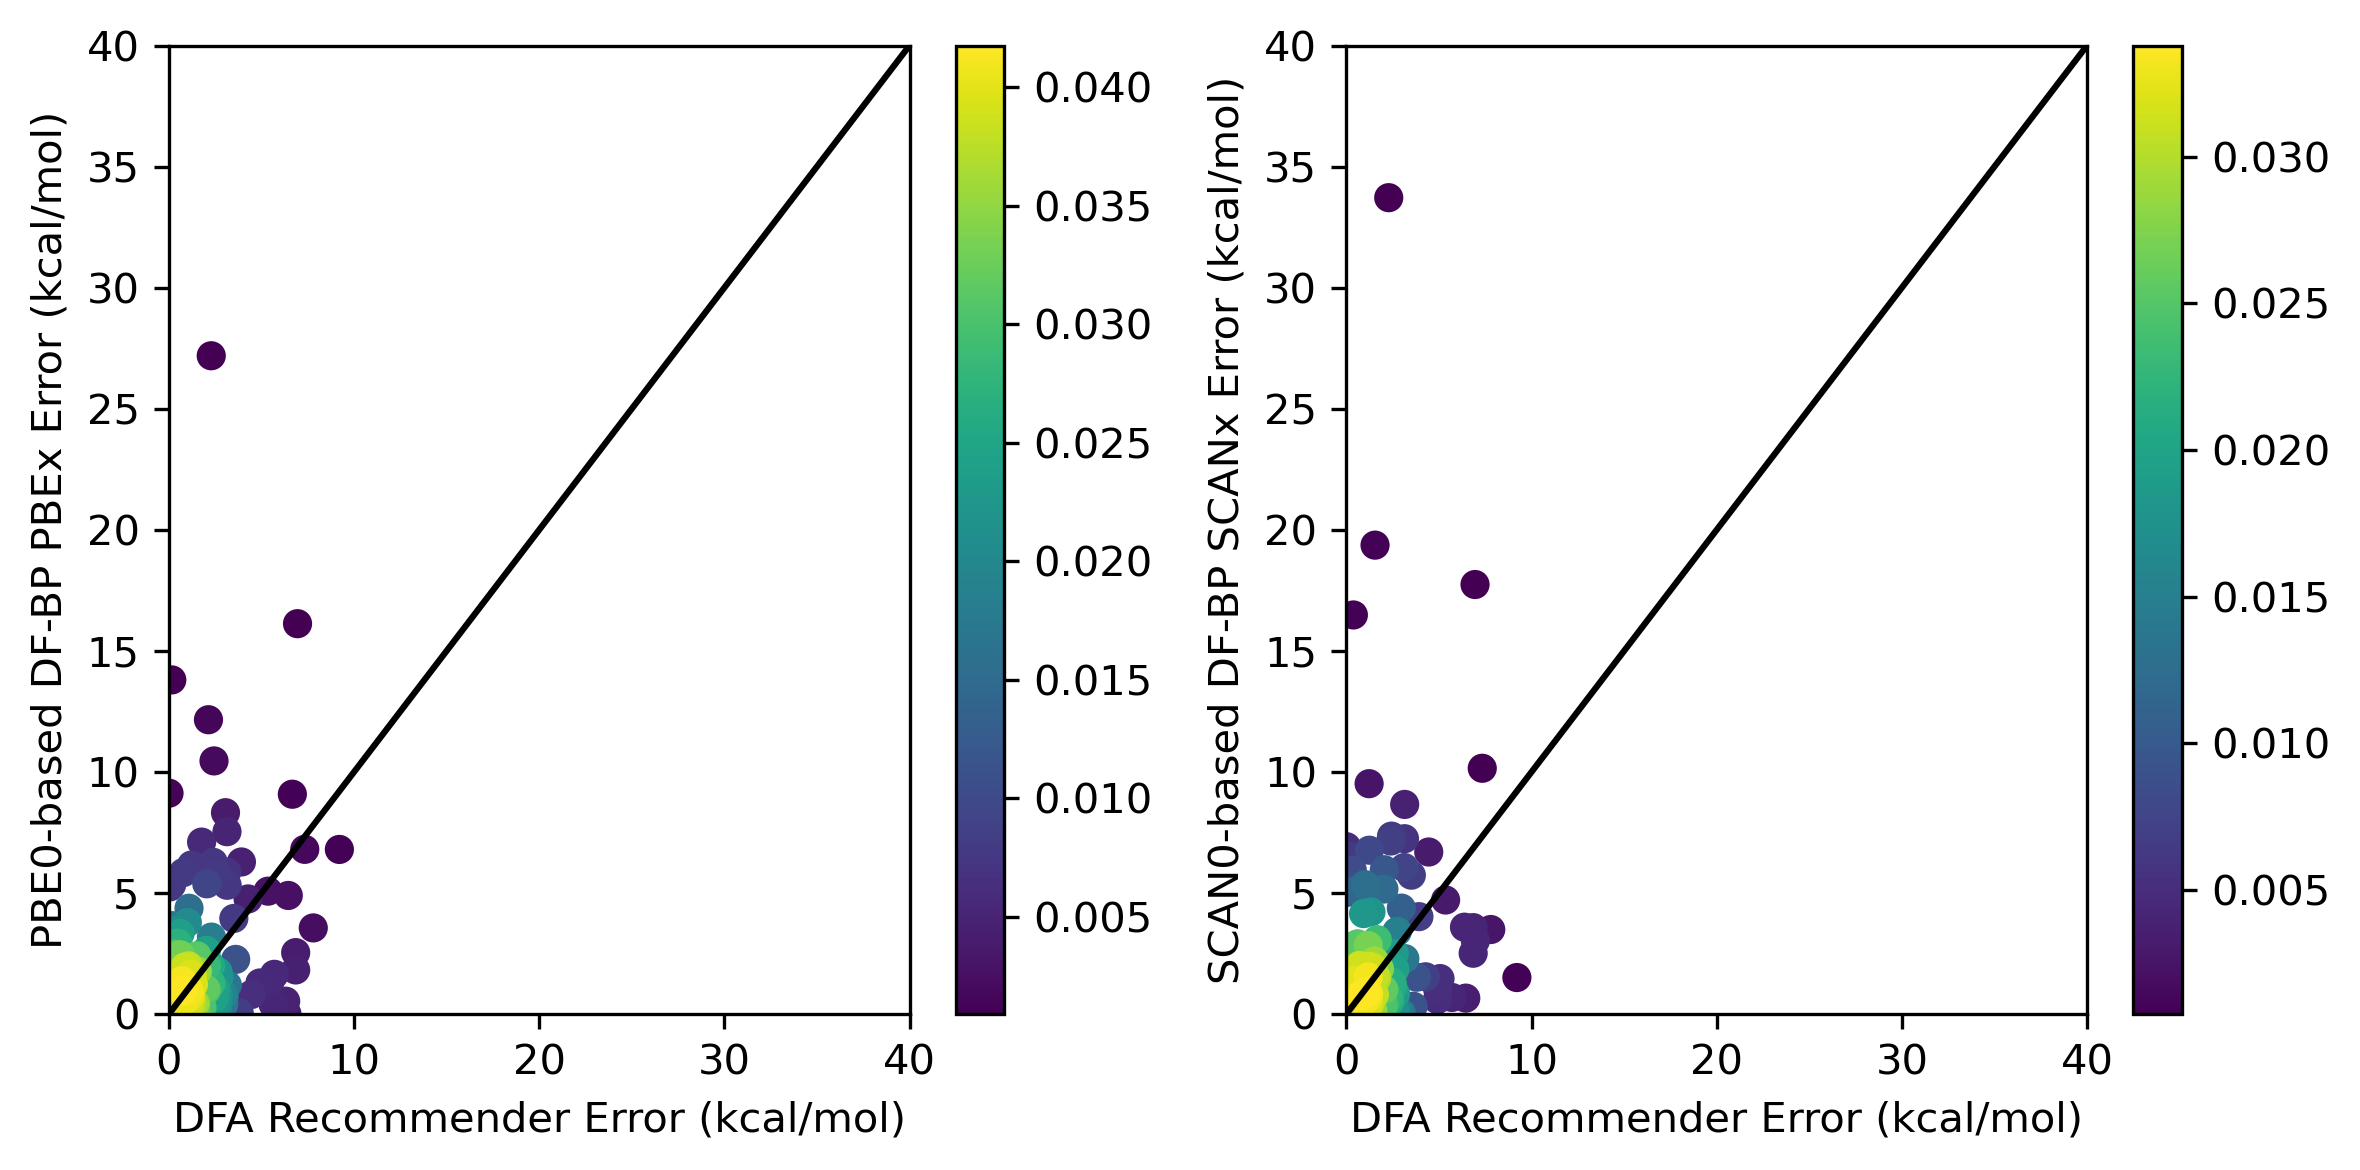

In [30]:
from scipy.stats import gaussian_kde

#parity plots
#validation

pbe_df = pd.read_csv('DF-BP/pbe0_opt-dfarec/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
pbe_df['hfxrec_err'] = np.nan
pbe_df['dfarec_err'] = np.nan

scan_df = pd.read_csv('DF-BP/scan0_opt-dfarec/BP_predictions_hyperparams-val.csv').set_index('Unnamed: 0')
scan_df['hfxrec_err'] = np.nan
scan_df['dfarec_err'] = np.nan

dataset = 'vss'
df = vss_452
sse_df = vss_sse_df
hfx_df = vss_hfx_df

pbe_errors = []
scan_errors = []

for struct in pbe_df.index.to_list():
    reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
    pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df=pbe_df)
    if pbe_energy is not None:
        pbe_df['hfxrec_err'][struct] = np.abs(reference - pbe_energy)
    else:
        pbe_df['hfxrec_err'][struct] = np.nan
    pbe_df['dfarec_err'][struct] = ast.literal_eval(dfa_vss.loc[struct]['errs_t'])[0]

for struct in scan_df.index.to_list():
    reference = vss_452.loc[struct]['dlpno-CCSD_T.vertsse']
    scan_energy = pred_energy(struct, 'scan', dataset, pred_df=scan_df)
    if scan_energy is not None:
        scan_df['hfxrec_err'][struct] = np.abs(reference - scan_energy)
    else:
        scan_df['hfxrec_err'][struct] = np.nan
    scan_df['dfarec_err'][struct] = ast.literal_eval(dfa_vss.loc[struct]['errs_t'])[0]

pbe_df = pbe_df.dropna(subset=['hfxrec_err'])
scan_df = scan_df.dropna(subset=['hfxrec_err'])


fig, ax = plt.subplots(ncols=2, figsize=(8,4), dpi=300)

x, y = pbe_df['dfarec_err'], pbe_df['hfxrec_err']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cax = ax[0].scatter(x, y, c=z)
fig.colorbar(cax)
ax[0].plot([0,50], [0,50], color='black')

x, y = scan_df['dfarec_err'], scan_df['hfxrec_err']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cax = ax[1].scatter(x, y, c=z)
fig.colorbar(cax)
ax[1].plot([0,50], [0,50], color='black')

ax[0].set_xlim((0, 40))
ax[0].set_ylim((0, 40))
ax[1].set_xlim((0, 40))
ax[1].set_ylim((0, 40))

ax[0].set_xlabel('DFA Recommender Error (kcal/mol)')
ax[0].set_ylabel('PBE0-based DF-BP PBEx Error (kcal/mol)')
ax[1].set_xlabel('DFA Recommender Error (kcal/mol)')
ax[1].set_ylabel('SCAN0-based DF-BP SCANx Error (kcal/mol)')

fig.tight_layout()

In [31]:
scan_df.sort_values('dfarec_err', ascending=False)

,PBE Target,PBE Prediction,SCAN Target,SCAN Prediction,hfxrec_err,dfarec_err
Unnamed: 0,,,,,,
mn_3_cyanide-C-0-d1_cyanide-C-0-d1_cyanide-C-0-d1_pyridine-N-3-0_pyridine-N-3-0_pyridine-N-3-0_5,46.16,37.21,36.04,33.44,1.51,9.21
cr_2_misc-C-4-0_misc-C-4-0_misc-C-4-0_acetonitrile-N-1-0_misc-C-4-0_acetonitrile-N-1-0_5,10.93,31.71,4.20,8.72,3.50,7.80
cr_3_pyridine-N-3-0_pyridine-N-3-0_pyridine-N-3-0_pyridine-N-3-0_hydroxyl-O-0-d1_hydroxyl-O-0-d1_4,100.00,45.43,100.00,37.91,10.15,7.34
co_2_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_acetonitrile-N-1-0_imidazole-N-2-0_4,23.14,38.29,39.45,32.41,3.04,6.97
cr_3_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_chloride-Cl-0-d1_SH2-S-0-0_SH2-S-0-0_4,100.00,58.41,100.00,79.19,17.74,6.95
...,...,...,...,...,...,...
fe_2_phosphine-P-0-0_phosphine-P-0-0_phosphine-P-0-0_ammonia-N-0-0_phosphine-P-0-0_ammonia-N-0-0_5,35.03,36.81,37.64,38.79,0.83,0.12
fe_2_formaldehyde-O-1-0_formaldehyde-O-1-0_formaldehyde-O-1-0_formaldehyde-O-1-0_formaldehyde-O-1-0_acetonitrile-N-1-0_5,31.31,30.91,36.60,35.55,0.67,0.09
co_3_cs-C-0-0_cs-C-0-0_cs-C-0-0_cs-C-0-0_hydroxyl-O-0-d1_hydroxyl-O-0-d1_5,25.08,30.06,31.42,31.35,0.03,0.06


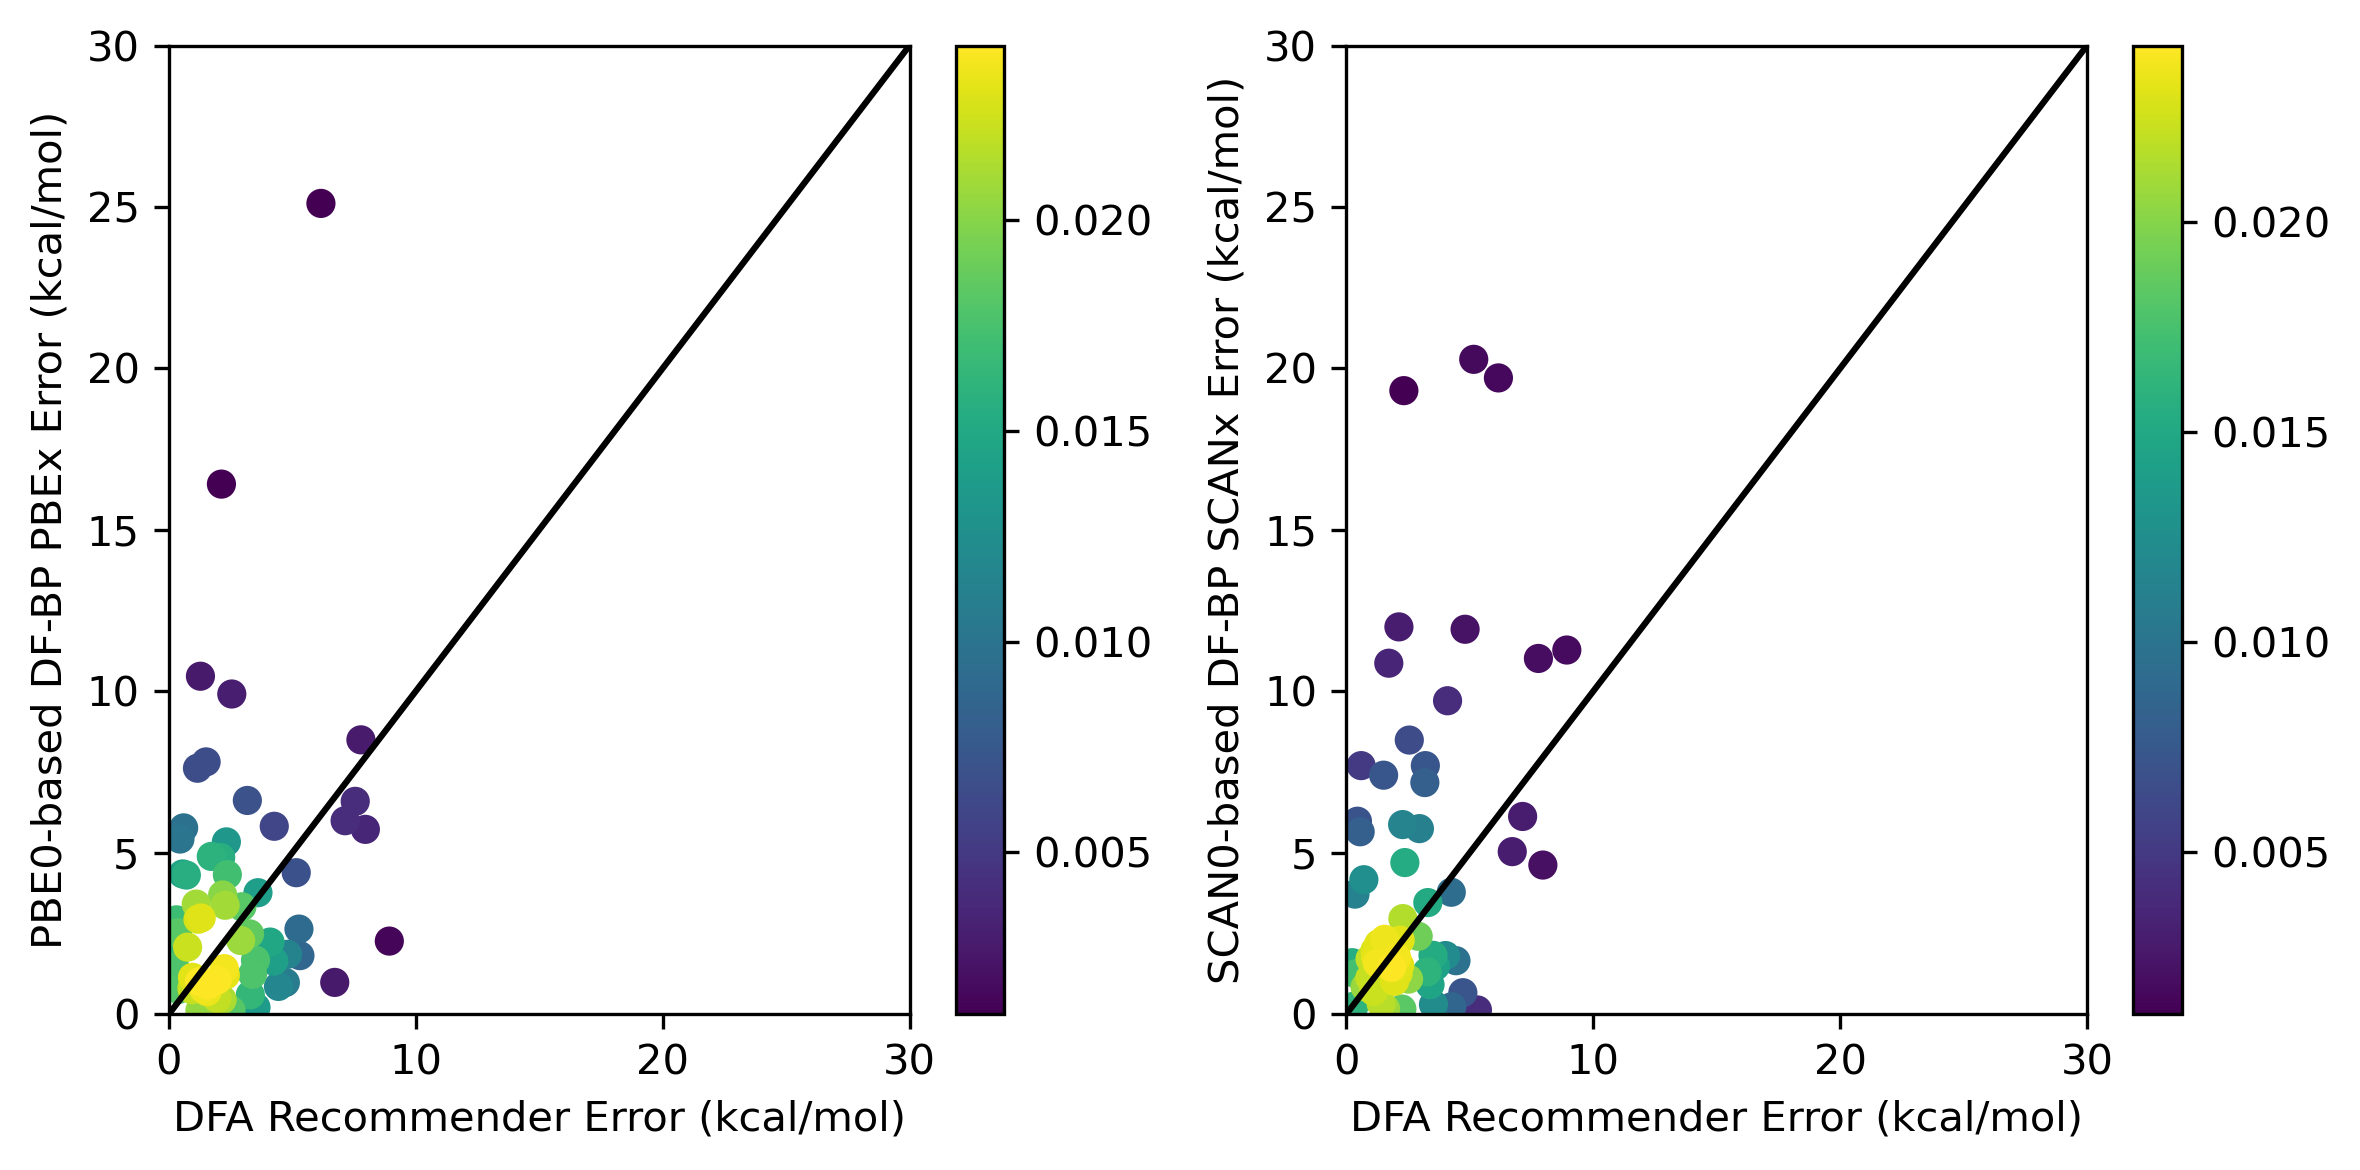

In [32]:
#parity plots
#test

pbe_df = pd.read_csv('DF-BP/pbe0_opt-dfarec/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
pbe_df['hfxrec_err'] = np.nan
pbe_df['dfarec_err'] = np.nan

scan_df = pd.read_csv('DF-BP/scan0_opt-dfarec/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
scan_df['hfxrec_err'] = np.nan
scan_df['dfarec_err'] = np.nan

dataset = 'csd'
df = csd_76
sse_df = csd_sse_df
hfx_df = csd_hfx_df

pbe_errors = []
scan_errors = []

for struct in pbe_df.index.to_list():
    reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
    pbe_energy = pred_energy(struct, 'pbe', dataset, pred_df=pbe_df)
    if pbe_energy is not None:
        pbe_df['hfxrec_err'][struct] = np.abs(reference - pbe_energy)
    else:
        pbe_df['hfxrec_err'][struct] = np.nan
    pbe_df['dfarec_err'][struct] = ast.literal_eval(dfa_csd.loc[struct]['errs_t'])[0]

for struct in scan_df.index.to_list():
    reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
    scan_energy = pred_energy(struct, 'scan', dataset, pred_df=scan_df)
    if scan_energy is not None:
        scan_df['hfxrec_err'][struct] = np.abs(reference - scan_energy)
    else:
        scan_df['hfxrec_err'][struct] = np.nan
    scan_df['dfarec_err'][struct] = ast.literal_eval(dfa_csd.loc[struct]['errs_t'])[0]

pbe_df = pbe_df.dropna(subset=['hfxrec_err'])
scan_df = scan_df.dropna(subset=['hfxrec_err'])


fig, ax = plt.subplots(ncols=2, figsize=(8,4), dpi=300)

x, y = pbe_df['dfarec_err'], pbe_df['hfxrec_err']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cax = ax[0].scatter(x, y, c=z)
fig.colorbar(cax)
ax[0].plot([0,50], [0,50], color='black')

x, y = scan_df['dfarec_err'], scan_df['hfxrec_err']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
cax = ax[1].scatter(x, y, c=z)
fig.colorbar(cax)
ax[1].plot([0,50], [0,50], color='black')

ax[0].set_xlim((0, 30))
ax[0].set_ylim((0, 30))
ax[1].set_xlim((0, 30))
ax[1].set_ylim((0, 30))

ax[0].set_xlabel('DFA Recommender Error (kcal/mol)')
ax[0].set_ylabel('PBE0-based DF-BP PBEx Error (kcal/mol)')
ax[1].set_xlabel('DFA Recommender Error (kcal/mol)')
ax[1].set_ylabel('SCAN0-based DF-BP SCANx Error (kcal/mol)')

fig.tight_layout()

In [33]:
scan_df.sort_values('dfarec_err', ascending=False)

,PBE Target,PBE Prediction,SCAN Target,SCAN Prediction,hfxrec_err,dfarec_err
Unnamed: 0,,,,,,
Fe_KAWTUX_comp_2_33,42.62,48.20,41.16,26.01,11.28,8.93
Co_ADETCO_comp_0_3111,25.70,18.44,24.12,17.73,4.62,7.96
Fe_AQIYII_comp_0_21111,21.63,31.07,19.87,33.19,11.02,7.78
Co_LOFFUH_comp_0_321,35.32,30.17,33.07,25.46,6.12,7.14
Co_PODWAG_comp_0_222,26.46,33.40,26.03,32.61,5.03,6.72
...,...,...,...,...,...,...
Fe_RUHLUB_comp_0_411,42.60,38.70,36.38,40.09,3.72,0.35
Fe_CEHHON_comp_0_111111,35.76,32.72,38.43,38.08,0.25,0.31
Co_CEWTUT_comp_0_42,26.96,28.20,26.57,24.46,1.59,0.24
